<div align="center">

# Social Graphs and Interactions 02805


## Assignment 2


#### Group 67

**Made By:**  
Nicklas Thorvald Kiær, s216137\
Alexander Vaaben, s214958\
Oliver Brandt, s216162


*4/11/2025*

---

</div>


## Part 1 - Analyze the network

For this part of the assignement, the network is initially created the same way it was for assignment 1. Whereafter the analysis is performed.

In [ ]:
import os
import re
import networkx as nx
import math
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean, median, mode, StatisticsError

In [17]:
# get artists from dataset
artist_dir = 'artists'
artist_files = [f for f in os.listdir(artist_dir) if f.endswith('.txt')]
artist_names = [os.path.splitext(f)[0] for f in artist_files]
artist_set = set(artist_names)

G = nx.DiGraph()
G.add_nodes_from(artist_names)

wiki_url_pattern = re.compile(r'https?://en\.wikipedia\.org/wiki/([^\s\]#]+)')


for filename in artist_files:
    artist = os.path.splitext(filename)[0]
    filepath = os.path.join(artist_dir, filename)
    with open(filepath, 'r', encoding='utf-8') as f:
        wikitext = f.read()

    # Find all internal wiki links
    links = re.findall(r'\[\[(.*?)\]\]', wikitext)
    for link in links:
        target = link.split('|')[0].strip().replace('/', '_').replace(' ', '_')
        if target in artist_set and target != artist:
            G.add_edge(artist, target)

print(f"Directed graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# remove inactive nodes, and node: AllMusic and node: rock_music
active_nodes = [node for node in G.nodes() if G.degree(node) > 0]

G_clean = G.subgraph(active_nodes).copy()
G_clean.remove_nodes_from(["rock_music", "AllMusic"])


Directed graph: 490 nodes, 7943 edges


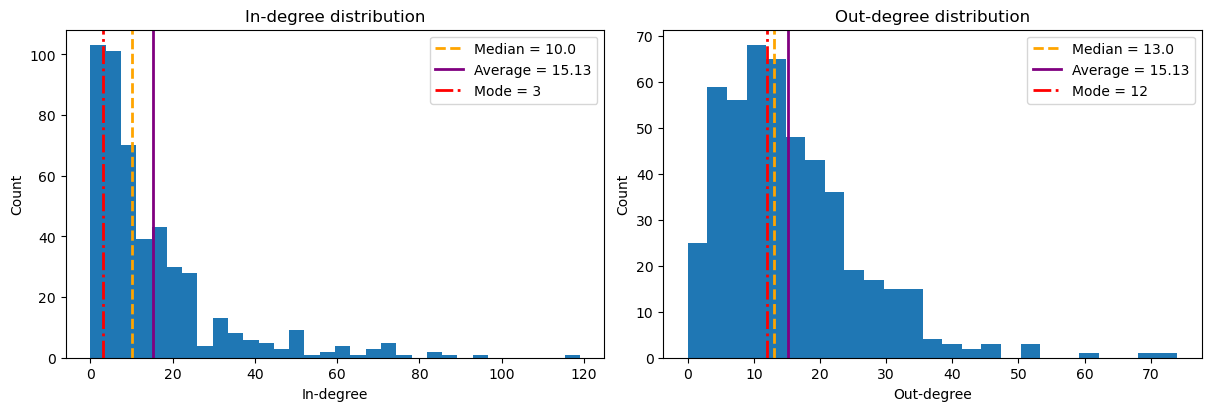

In [39]:
node_names = list(G_clean.nodes())
in_deg_dict = dict(G_clean.in_degree())
out_deg_dict = dict(G_clean.out_degree())
in_degrees = [in_deg_dict[n] for n in node_names]
out_degrees = [out_deg_dict[n] for n in node_names]


def describe_degree(degrees):
    avg = mean(degrees)
    med = median(degrees)
    try:
        mod = mode(degrees)
    except StatisticsError:
        mod = "No unique mode"
    min_val = min(degrees)
    max_val = max(degrees)
    return avg, med, mod, min_val, max_val

in_avg, in_med, in_mod, in_min, in_max = describe_degree(in_degrees)
out_avg, out_med, out_mod, out_min, out_max = describe_degree(out_degrees)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# In-degree histogram
axes[0].hist(in_degrees, bins='auto')
axes[0].axvline(in_med, linestyle='--', linewidth=2, label=f"Median = {in_med:.1f}", color='orange')
axes[0].axvline(in_avg, linestyle='-', linewidth=2, label=f"Average = {in_avg:.2f}", color='purple')
axes[0].axvline(in_mod, linestyle='-.', linewidth=2, label=f"Mode = {in_mod}", color='red')
axes[0].set_title("In-degree distribution")
axes[0].set_xlabel("In-degree")
axes[0].set_ylabel("Count")
axes[0].legend()

# Out-degree histogram
axes[1].hist(out_degrees, bins='auto')
axes[1].axvline(out_med, linestyle='--', linewidth=2, label=f"Median = {out_med:.1f}", color='orange')
axes[1].axvline(out_avg, linestyle='-', linewidth=2, label=f"Average = {out_avg:.2f}", color='purple')
axes[1].axvline(out_mod, linestyle='-.', linewidth=2, label=f"Mode = {out_mod}", color='red')
axes[1].set_title("Out-degree distribution")
axes[1].set_xlabel("Out-degree")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.show()

### Interpretation of Degree Statistics

Both in- and out-degree distributions are **right-skewed** (meaning the average is larger than the median). This means a few artists have very high connectivity while most have lower degrees. However the difference it more pronounced in the *in-degree*

The **mode** values show that most artists link out to many others (out-degree mode = 12), but are not linked to as often (in-degree mode = 3). This fits with how Wikipedia pages usually are written. Band pages typically may mention a lot of other artists as influences, but only a small number of highly influential bands get referenced by many others.

The maximum **in-degree** (119) is higher than the maximum **out-degree** (74), again indicating the presence of strong “hub” nodes, as in, artists that many other pages point to.

In the next part, we will take a look at the degree centrality fo the network, to gain a stronger understanding of the top players in the network. 

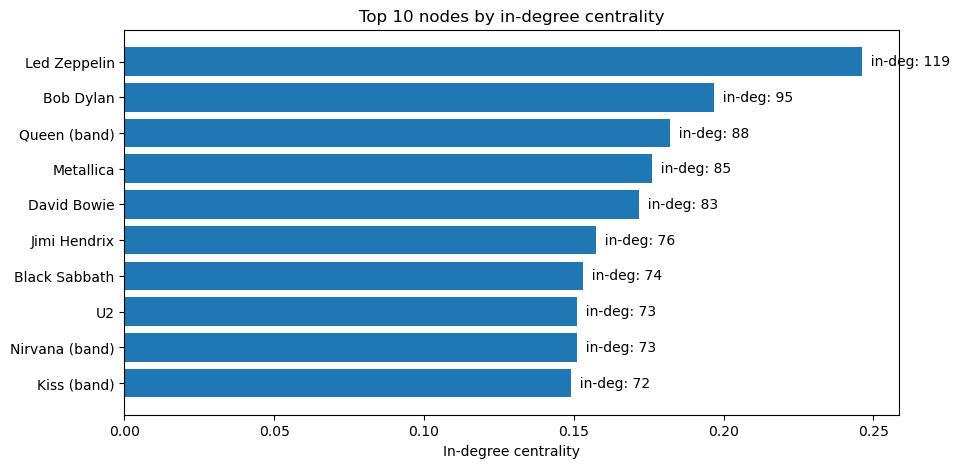

In [ ]:
in_centrality = nx.in_degree_centrality(G_clean)

top_n = min(10, len(in_centrality))
top_nodes = sorted(in_centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]

names = [n for n, c in top_nodes]
names_pretty = [n.replace('_', ' ') for n in names]
centralities = [c for n, c in top_nodes]
indegs = [dict(G_clean.in_degree()).get(n, 0) for n in names]

fig, ax = plt.subplots(figsize=(10, 5))
y_pos = np.arange(len(names))
ax.barh(y_pos, centralities)
ax.set_yticks(y_pos, labels=names_pretty)
ax.invert_yaxis()
ax.set_xlabel("In-degree centrality")
ax.set_title("Top 10 nodes by in-degree centrality")

# annotate in-degree on bars
for i, (val, indeg) in enumerate(zip(centralities, indegs)):
    ax.text(val, i, f"  in-deg: {indeg}", va='center')

plt.show()

### In-Degree Centrality Interpretation

The **in-degree centrality** measures the amount of links that point to a node, and in this case, the amount of rock bands that reference a specific other rock band in thier wiki article. 

We can see from printing the top 10 artists in order of **in-degree centrality** that these are all wvery well know, respected, and (most importantly) influencial rock bands. 

The top one being *Led Zeppelin*, who are linked to by a whopping 24% of the entire rock band network. And by reading up on them on thier wiki page, it is easy to see why. They are widely known for having placed thier mark on the rock music world. Being active from around 1970 to 1980. They had 10 years of influencing the genre. And were even inducted in the *Rock and Roll Hall of Fame* in 1995. 

This shows how influencial the band is, and therefore this also aligns with them being the most linked-to rock band on other rock band wikipedia pages.


Another aspect worth noting is the amount of different sub-genres being represented in the top 10 list. We see bands like *Metallica* which are known for being more of a **heavy metal** band. As well as Bob Dylan, who somie may say leans more into the **folk** genre. This further shows how broad and wide spanning the rock genre as a whole is. But more importantly, it shows how these bands that are often refered to as the "fathers" of thier genre, have had the influence in the real world, but also through thier wikipedia reach. They are all "pillars" in thier genre, and are also hubs in the wikipedia rock band network. 

Next, we will take a look into the assortativity of the newtork. 

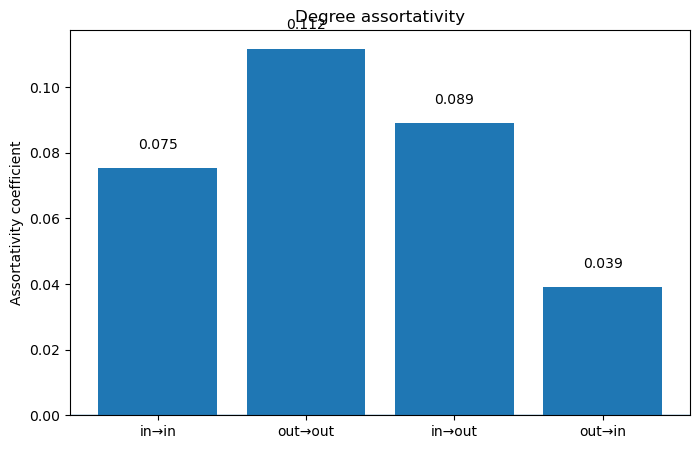

In [40]:
in_assortativity = nx.degree_assortativity_coefficient(G_clean, x='in', y='in')
out_assortativity = nx.degree_assortativity_coefficient(G_clean, x='out', y='out')
in_out_assortativity = nx.degree_assortativity_coefficient(G_clean, x='in', y='out')
out_in_assortativity = nx.degree_assortativity_coefficient(G_clean, x='out', y='in')

labels = ["in→in", "out→out", "in→out", "out→in"]
values = [in_assortativity, out_assortativity, in_out_assortativity, out_in_assortativity]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(labels))
ax.bar(x, values)
ax.axhline(0, linewidth=1)
ax.set_xticks(x, labels)
ax.set_ylabel("Assortativity coefficient")
ax.set_title("Degree assortativity")
for i, v in enumerate(values):
    ax.text(i, v + (0.005 if v >= 0 else -0.015), f"{v:.3f}", ha='center', va='bottom' if v >= 0 else 'top')
plt.show()

### Assortativity Interpretation

We see that all of the assortativity values are close to 0, but slightly positive. This suggests that the network is *weakly assortative*. Meaning that there is a slight tendency for some nodes with similar degrees, to link to eachother. But the effect is not really that strong. 

The strongest value of teh four is the **Out-degree assortativity** which is 0.1118, even this is still a pretty weak tendency, but it is nontheless still a tendency, for the pages which link out to many artists, to link to other pages that similarily also link out to many artists. 

The **in -> out** and **out -> in** are both very close to 0, indicating that hubs do not have a tendency to connected to other hubs. No matter if they are *influencial hubs* or *influenced hubs*.

This all counts towards the network being classified more as a neutral mixing of  nodes, than one categorized by importance in influenciality. 

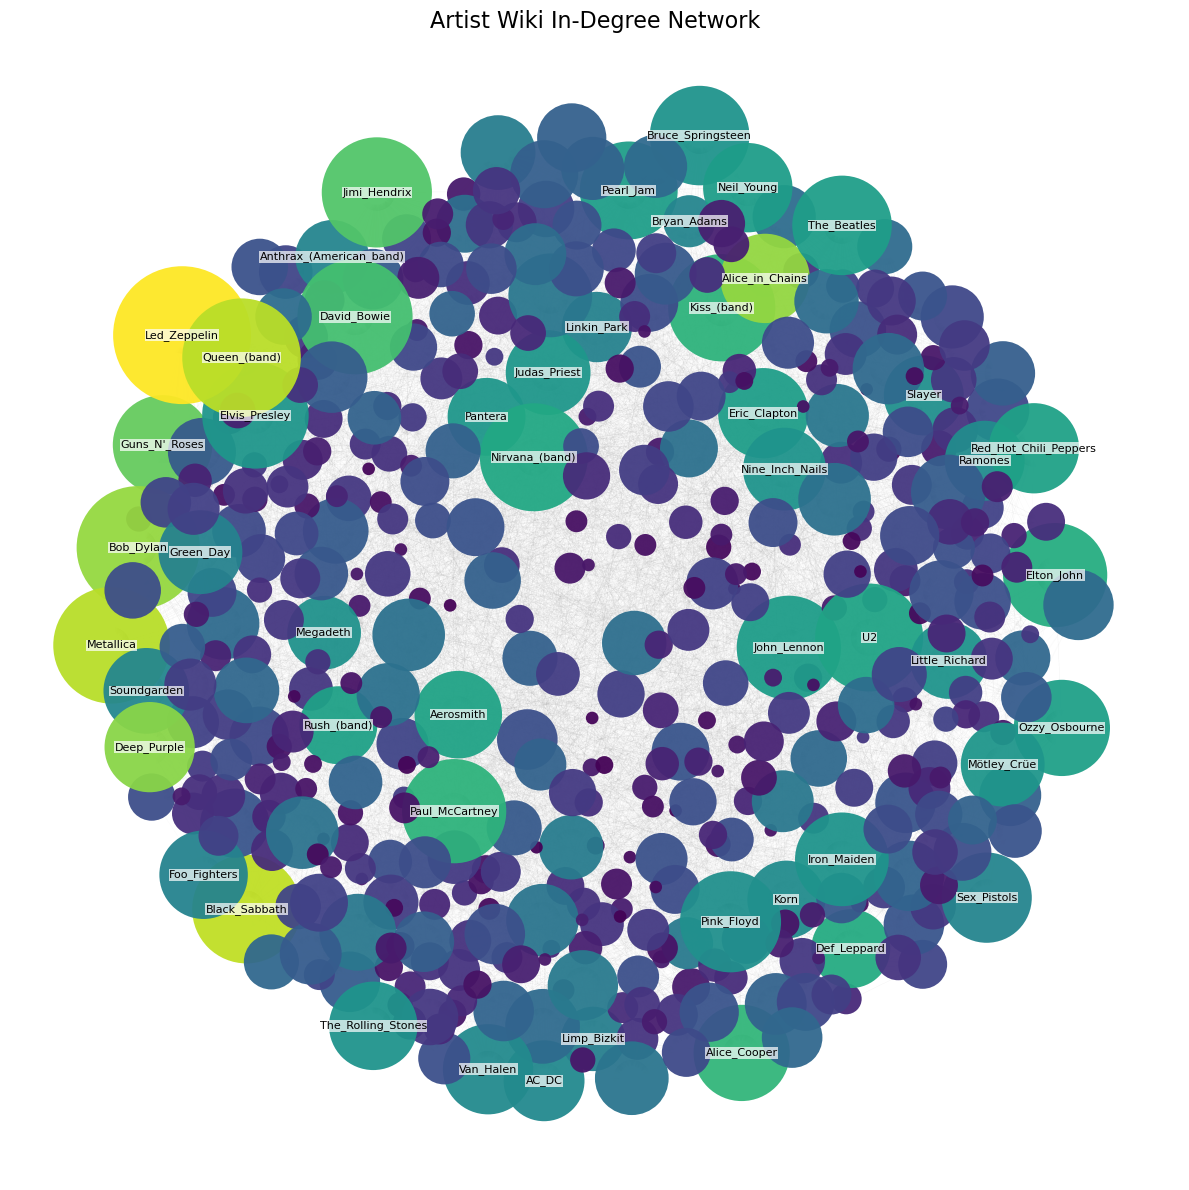

In [ ]:
pos = nx.forceatlas2_layout(
    G_clean, 
    node_size=in_centrality, 
    seed=42,
    max_iter=1000, 
    gravity=1.5,           
    jitter_tolerance=0.02, 
    scaling_ratio=2.8,     
)

# scaling this up for visibility
node_sizes = [40000 * in_centrality[n] for n in G_clean.nodes()]

# color the nodes depending on thne degree
deg_dict = dict(G_clean.degree())
node_degrees = [deg_dict[n] for n in G_clean.nodes()]

# only show the top 50
top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:50]
labels = {n: n for n in top_nodes}

plt.figure(figsize=(12, 12), dpi=100)

# draw edges faintly for less clutter
nx.draw_networkx_edges(
    G_clean, pos,
    width=0.25,
    alpha=0.05,
    edge_color="gray",
)

nx.draw_networkx_nodes(
    G_clean, pos,
    node_size=node_sizes,
    node_color=node_degrees,
    cmap=plt.cm.viridis,
    alpha=0.95,
    linewidths=0.0,
)

nx.draw_networkx_labels(
    G_clean, pos,
    labels=labels,
    font_size=8,
    font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.2),
)

plt.title("Rock Band In-Degree Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


The above visualisation of the network is created using forceatlas2, which is an algorithm that creates the positions for the nodes based on "physics". Simply put, it makes nodes converge into more fitting positions through multiple iterations. 

The nodes are sized according to the in-degree of it, as well as colored according to the general degree of the node. We can see again how the influencial, older rock bands are larger, and brighter.